# Compute gcorr diseases and phenotypes (ldscr)

Last modification: 

Page with the ldsr files:
https://nealelab.github.io/UKBB_ldsc/downloads.html#ldsc_sumstat_files

In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import glob, os
from os import listdir
from os.path import isfile, join
from datetime import datetime

In [74]:

### Copied from config

MAIN_LABELS='mean_angle_taa,mean_angle_tva,tau1_vein,tau1_artery,ratio_AV_DF,eq_CRAE,ratio_CRAE_CRVE,D_A_std,D_V_std,eq_CRVE,ratio_VD,VD_orig_artery,bifurcations,VD_orig_vein,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter'
MAIN_NAMES='A temporal angle,V temporal angle,V tortuosity,A tortuosity,ratio tortuosity,A central retinal eq,ratio central retinal eq,A std diameter,V std diameter,V central retinal eq,ratio vascular density,A vascular density,bifurcations,V vascular density,A median diameter,V median diameter,ratio median diameter'
traits_phenos = list(MAIN_LABELS.split(","))
traits_phenos_new = list(MAIN_NAMES.split(","))
 
only_continuos = True # True

path = '/NVME/decrypted/scratch/multitrait/UK_BIOBANK_PREPRINT/gwas/gcorr_diseases/'


### Read from csv
file_info_name='pheno_diseases_info.csv'

df_inf_csv = pd.read_csv('~/retina-phenotypes/complementary/'+ file_info_name)
print('len(df_inf_csv):', len(df_inf_csv))
df_inf_filt =  df_inf_csv[df_inf_csv['lscr_analysis'] == 'TRUE']
print('len(df_inf_filt):', len(df_inf_filt))

if only_continuos == True:
    df_inf_filt =  df_inf_csv[df_inf_csv['dtype'] == 'con']
    print('len(df_inf_filt):', len(df_inf_filt))
traits_all = list(df_inf_filt['datafield'].values)
traits_all_new = list(df_inf_filt['final_name'].values)

len(df_inf_csv): 89
len(df_inf_filt): 23
len(df_inf_filt): 11


In [75]:
# path This we can read from config
def try_to_compute_all(traits_all):
    
    save_path = path
    l_diseases_all=[]
    for trait in traits_all:
        #print(trait)
        for file in os.listdir(path):
            #print(file, '\n')
            if file.startswith(trait):
                if (file.endswith('.tsv.bgz'))  or (file.endswith('.tsv')):
                    print('PHENO', trait)
                    print(file, '\n')
                    #df_ss = pd.read_csv(path + file,  nrows=1, sep='\t')
                    #print(df_ss['N'].iloc[0])
                    #print(file)
                    data={
                        'pheno':  trait,
                        'file':  file
                        #,'N': df_ss['N'].iloc[0],
                        }
                    l_diseases_all.append(data)

    df_diseases_all =pd.DataFrame(l_diseases_all)
    #file_name_end = '_irnt.gwas.imputed_v3.both_sexes.tsv'

    l_traits_file=[]
    for trait in traits_phenos:
        file_pheno= trait + '__munged.sumstats.gz'
        l_traits_file.append(file_pheno)

    traits_files = l_traits_file + list(df_diseases_all['file'])
    traits_names = traits_phenos + list(df_diseases_all['pheno'])
    print(len(traits_files), len(l_traits_file), len(list(df_diseases_all['file'])))
    return df_diseases_all

df_diseases_all = try_to_compute_all(traits_all)

PHENO 4079
4079_irnt.ldsc.imputed_v3.both_sexes.tsv 

PHENO 4080
4080_irnt.ldsc.imputed_v3.both_sexes.tsv 

PHENO 102
102_irnt.ldsc.imputed_v3.both_sexes.tsv 

PHENO 21021
21021_irnt.ldsc.imputed_v3.both_sexes.tsv 

PHENO 30760
30760_irnt.imputed_v3.ldsc.both_sexes.tsv 

PHENO 30780
30780_irnt.imputed_v3.ldsc.both_sexes.tsv 

PHENO 30870
30870_irnt.imputed_v3.ldsc.both_sexes.tsv 

PHENO 30750
30750_irnt.imputed_v3.ldsc.both_sexes.tsv 

PHENO 21001
21001_irnt.ldsc.imputed_v3.both_sexes.tsv 

26 17 9


In [76]:
#df_diseases_all= df_diseases_all.drop_duplicates(subset='pheno')
df_diseases_all

,pheno,file
0,4079,4079_irnt.ldsc.imputed_v3.both_sexes.tsv
1,4080,4080_irnt.ldsc.imputed_v3.both_sexes.tsv
2,102,102_irnt.ldsc.imputed_v3.both_sexes.tsv
3,21021,21021_irnt.ldsc.imputed_v3.both_sexes.tsv
4,30760,30760_irnt.imputed_v3.ldsc.both_sexes.tsv
5,30780,30780_irnt.imputed_v3.ldsc.both_sexes.tsv
6,30870,30870_irnt.imputed_v3.ldsc.both_sexes.tsv
7,30750,30750_irnt.imputed_v3.ldsc.both_sexes.tsv
8,21001,21001_irnt.ldsc.imputed_v3.both_sexes.tsv


In [77]:
#datafields_irnt = [ dat + "_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz" for dat in traits_reduced]
datafields_irnt = [ dat for dat in df_diseases_all['file']]
datafields_pheno = [ dat + "__munged.sumstats.gz" for dat in traits_phenos]
diseasess_tra_aux = [ dat for dat in df_diseases_all['pheno']]

traits_col_index = traits_phenos + diseasess_tra_aux
traits_names = datafields_pheno + datafields_irnt


In [78]:
### IMPORTANT: If you have not same file go back to diseases_traits and comment 
### the phenotypes that are missing

In [79]:
# filter the files names containing 2 traits
def read_ldsr(traits_files, traits_col_index):
    df_cov=pd.DataFrame(columns =traits_col_index, index=traits_col_index)
    df_corr=pd.DataFrame(columns =traits_col_index, index=traits_col_index)
    df_std=pd.DataFrame(columns =traits_col_index, index=traits_col_index)
    #2976_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz_4700_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz.log
    #2976_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz_D_A_std__munged.sumstats.gz.log

    for i  in range(len(traits_files)):
        for j in range(len(traits_files)):
            h2 = []
            file_both_name = traits_files[i]+'_'+ traits_files[j]+'.log'
            dir_traitsfile = path+file_both_name
            #print(dir_traitsfile)
            with open(dir_traitsfile) as fp:
                #print(fp)
                #print(traits_files[i],traits_files[j])
                Lines = fp.readlines()
                for line in Lines:
                    #print(line)
                    split = line.split()
                    if('gencov:' in split):
                        df_cov.iloc[i][j] = round(float(split[ split.index('gencov:') +1 ]),2)
                        df_cov.iloc[j][i] = round(float(split[ split.index('gencov:') +1 ]),2)
                        #print(split)
                    if('Correlation:' in split):
                        #print(line)
                        #print(split)
                        df_corr.iloc[i][j] = round(float(split[ split.index('Correlation:') +1 ]),2)
                        df_corr.iloc[j][i] = round(float(split[ split.index('Correlation:') +1 ]),2)
                        #print(array2)
                        #print(split )
                        #print( df_corr.iloc[i][j], float(split[ split.index('Correlation:') +1 ]) )
                        #print( df_corr.iloc[j][i], float(split[ split.index('Correlation:') +1 ]))
                        df_std.iloc[i][j] = split[3]
                        df_std.iloc[j][i] = split[3]
    return df_cov, df_corr, df_std

df_cov, df_corr, df_std2 = read_ldsr(traits_names, traits_col_index)     



In [80]:
def rename_col_index(df, l_phenos_old, l_phenos_new, l_diseases_old, l_diseases_new):
      df.rename(columns=dict(zip(l_diseases_old, l_diseases_new)), inplace=True)
      df.rename(index=dict(zip(l_phenos_old, l_phenos_new)), inplace=True)
      return df

def detele_col_index(df, l_phenos_old, l_phenos_new, l_diseases_old, l_diseases_new):
      #print(l_phenos_old, l_phenos_new)
      df=df.drop(columns=l_phenos_old)
      #print(df.index)
      #print(l_diseases_old)
      #df=df.drop(index=l_diseases_old)
      df = df[df.index.isin(l_phenos_old)]
      #print(df)
      df= rename_col_index(df, l_phenos_old, l_phenos_new, l_diseases_old, l_diseases_new)    
      return df

df_corr_simpl = detele_col_index(df_corr, traits_phenos, traits_phenos_new, traits_all, traits_all_new)
df_std_simpl = detele_col_index(df_std2,  traits_phenos, traits_phenos_new, traits_all,  traits_all_new)

#df_std_simpl =  df_std2 #.astype(float)
#df_corr_simpl = df_corr.astype(float)
    

In [81]:
#df_std_simpl.drop_duplicates(inplace=True)
df_std_simpl = df_std_simpl.loc[:,~df_std_simpl.columns.duplicated()].copy()
df_std_simpl.columns

Index(['DBP', 'SBP', 'PR', 'PWASI', 'HDL', 'LDL', 'Triglycerides', 'HbA1c',
       'BMI'],
      dtype='object')

In [82]:
#df_std_simpl = df_std_simpl.astype(str)
for col in df_std_simpl.columns:
    #print(col)
    #print(df_std_simpl[col].head(3))
    df_std_simpl[col] = df_std_simpl[col].str.replace("(", "", regex=True)
    df_std_simpl[col] = df_std_simpl[col].str.replace(")", "", regex=True)

df_std_simpl=df_std_simpl.astype(float)
df_std_simpl=df_std_simpl.round(2)
df_std_simpl.dtypes

DBP              float64
SBP              float64
PR               float64
PWASI            float64
HDL              float64
LDL              float64
Triglycerides    float64
HbA1c            float64
BMI              float64
dtype: object

In [83]:
table_plot='False'

if table_plot=='True':
    #print(df_reducida.columns, df_std.columns)
    df = df_corr_simpl.astype(str) + ' (' + df_std_simpl.astype(str)+ ')'



    df_corr_simpl_aux = df_corr_simpl.copy()
    df_corr_simpl_aux = df_corr_simpl_aux.astype(float)

    rcolors = plt.cm.Greys(np.full(len(df.index), 0.15))
    ccolors = plt.cm.Greys(np.full(len(df.columns), 0.15))
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    #create table
    table = ax.table(cellText=df.values, 
                    #rowColours=rcolors,
                    colLabels=df.columns, 
                    rowLabels=df.index,
                    #colColours=ccolors,
                    rowLoc='center',
                    colLoc='center',
                    cellLoc='center',
                    cellColours=plt.cm.viridis(df_corr_simpl_aux.values, alpha=0.5),
                    loc='center',
                    fontsize=16,
                    colWidths=[0.15 for x in df.columns])


    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(3.7, 3.5) # make table a little bit larger
    fig.tight_layout()
    #plt.show()
    #fig.savefig(save_dir+str(DATE)+'_'+'ventile'+str(ventile_num)+'_diseases_gcorr.pdf', bbox_inches='tight',dpi=250)


# Figure genetic correlation with diseases

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5]),
 [Text(0.5, 0, 'A temporal angle'),
  Text(1.5, 0, 'V temporal angle'),
  Text(2.5, 0, 'V tortuosity'),
  Text(3.5, 0, 'A tortuosity'),
  Text(4.5, 0, 'ratio tortuosity'),
  Text(5.5, 0, 'A central retinal eq'),
  Text(6.5, 0, 'ratio central retinal eq'),
  Text(7.5, 0, 'A std diameter'),
  Text(8.5, 0, 'V std diameter'),
  Text(9.5, 0, 'V central retinal eq'),
  Text(10.5, 0, 'ratio vascular density'),
  Text(11.5, 0, 'A vascular density'),
  Text(12.5, 0, 'bifurcations'),
  Text(13.5, 0, 'V vascular density'),
  Text(14.5, 0, 'A median diameter'),
  Text(15.5, 0, 'V median diameter'),
  Text(16.5, 0, 'ratio median diameter')])

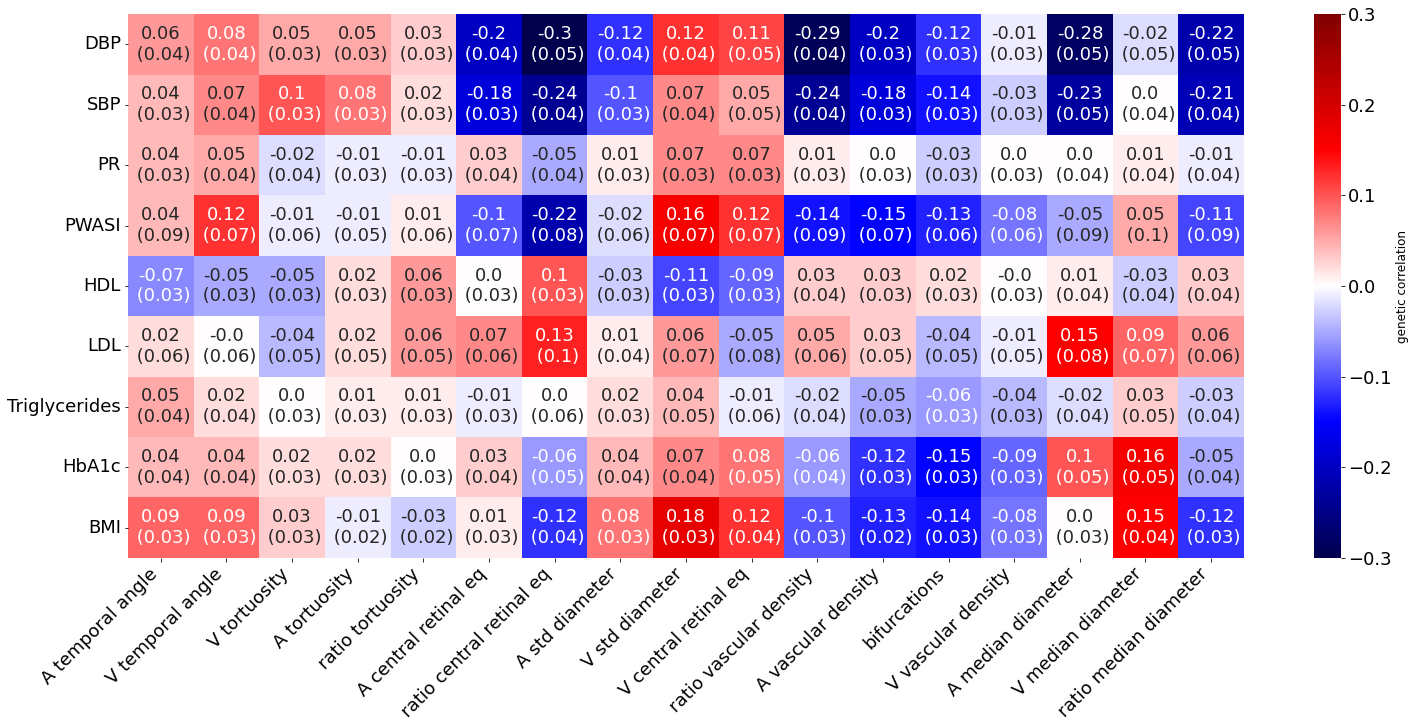

In [84]:
#print(df_corr_simpl.head(1))
df_corr_simpl= -1*df_corr_simpl.copy() ######harcoded!!!

df_corr_minus_std= (np.sign(df_corr_simpl))*((abs(df_corr_simpl) - abs(df_std_simpl)))
df_corr_minus_std = df_corr_minus_std.astype(float)

#print(df_corr_simpl.head(1))
df = df_corr_simpl.astype(str) + '\n (' + df_std_simpl.astype(str)+ ')'

df_corr_minus_std= df_corr_minus_std.T
df=df.T

df_corr_simpl = df_corr_simpl.astype(float)

plt.rcParams['font.size'] = '18'
#figsize_val_2=(30, 30)
if only_continuos == True:
    figsize_val_2=(25, 10)
else:
    figsize_val_2=(25, 25)
#figsize_val_2=(10, 10)
fig, ax = plt.subplots(figsize=figsize_val_2)
# fig1 = sns.heatmap(df_corr_minus_std, 
#             annot=df.values, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
#             cbar=True, #If not False
#             fmt="", #annot_kws={'weight': 'bold'}, 
#             vmin=-abs(df_corr_minus_std).max().max(),
#             vmax=abs(df_corr_minus_std).max().max(), 
#             cmap='seismic',alpha=1.0, cbar_kws={'label': 'minimum genetic correlation'},
#             ax=ax)

fig1 = sns.heatmap(df_corr_simpl.T, 
            annot=df.values, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #If not False
            fmt="", #annot_kws={'weight': 'bold'}, 
            vmin=-abs(df_corr_simpl.T).max().max(),
            vmax=abs(df_corr_simpl.T).max().max(), 
            cmap='seismic',alpha=1.0, cbar_kws={'label': 'genetic correlation'},
            ax=ax)
plt.xticks(rotation=45, ha='right')

# Figure 2: genetic correlation with diseases

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5]),
 [Text(0.5, 0, 'A temporal angle'),
  Text(1.5, 0, 'V temporal angle'),
  Text(2.5, 0, 'V tortuosity'),
  Text(3.5, 0, 'A tortuosity'),
  Text(4.5, 0, 'ratio tortuosity'),
  Text(5.5, 0, 'A central retinal eq'),
  Text(6.5, 0, 'ratio central retinal eq'),
  Text(7.5, 0, 'A std diameter'),
  Text(8.5, 0, 'V std diameter'),
  Text(9.5, 0, 'V central retinal eq'),
  Text(10.5, 0, 'ratio vascular density'),
  Text(11.5, 0, 'A vascular density'),
  Text(12.5, 0, 'bifurcations'),
  Text(13.5, 0, 'V vascular density'),
  Text(14.5, 0, 'A median diameter'),
  Text(15.5, 0, 'V median diameter'),
  Text(16.5, 0, 'ratio median diameter')])

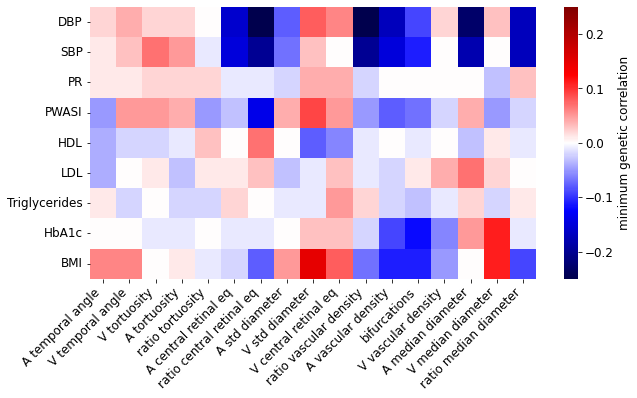

In [93]:
##min gcorr
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = '12'

if only_continuos == True:
    figsize_val=(10, 5)
else:
    figsize_val=(25, 25)

fig, ax = plt.subplots(figsize=figsize_val)
fig1 = sns.heatmap(df_corr_minus_std,  #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #If not False
            fmt="", #annot_kws={'weight': 'bold'}, 
            vmin=-abs(df_corr_minus_std).max().max(),
            vmax=abs(df_corr_minus_std).max().max(), 
            cmap='seismic',alpha=1.0, cbar_kws={'label': 'minimum genetic correlation'},
            ax=ax)
plt.xticks(rotation=45, ha='right')

In [ ]:
## TO DO:

# Filtering by dtype: 
#df_file_continuous= df_inf_filt[df_inf_filt['dtype']=='con']

#traits_new_continuous = list(df_inf_filt['final_name'].values)

# SCATTER PLOT PHENOTYPIC- GENETIC ASSOCIATION WITH DISEASES

In [ ]:
### genetic value == df_corr_minus_std OR df_corr (TO DECIDE)
### phenotypic value == betas

####Phenotypic association with diseases:
file_info_name='pheno_diseases_info.csv'
pheno_info_file = '/SSD/home/sofia/retina-phenotypes/complementary/'+str(file_info_name)
display_info=True
date='2022_11_23'
ventile='covar_fix'

diseases_dir ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_PREPRINT/diseases_cov/'
betas=pd.read_csv(diseases_dir+'reg_betas_.csv', index_col=0)
log10p=pd.read_csv(diseases_dir+'reg_log10p_.csv', index_col=0)
betas = betas.astype('float64') # in case betas was coded as object type
## Rename columns and index
df_inf_filt_LR =  df_inf_csv[df_inf_csv['main_supl']=='main']
df_inf_filt_LR = df_inf_filt_LR.append(df_inf_csv[df_inf_csv['main_supl']=='hr'])
list_diseases_LR = df_inf_filt_LR['name_LR'].values
list_diseases_LR_new = df_inf_filt_LR['final_name'].values 
betas= rename_col_index(betas, list(traits_phenos), list(traits_phenos_new), list(list_diseases_LR), list(list_diseases_LR_new)) 
## Diseases == y-axis and Vascular phenos == x-axis
betas = betas.T

In [ ]:
print('ATENTION! -> Phenoty and genetically we have different sizes, we do not have biyective function between them. So it is needed to make decisions')
print('len(df_corr_minus_std) and len(betas): ', len(df_corr_minus_std), len(betas))
print(df_corr_minus_std.index, betas.index)
list_intersection_phe_gen = list(set(df_corr_minus_std.index) & set(betas.index))
print('They have in common ', len(list_intersection_phe_gen), ' -> names: ', list_intersection_phe_gen)

In [ ]:
## PLOTS:

import scipy
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value, r_value**2

def phen_gen_scatter(df_1, df_2, name_title):
    df_index=df_1
    print(df_1.index)
    #df_index['index']= df_1.index
    #print(df_index['index'])

    fig = plt.gcf()
    fig.set_size_inches(10.5, 10.5)
    for col in df_1.columns:
        plt.scatter(df_1[col], df_2[col], label=col)
        r_value, r_value2 = rsquared(df_1[col], df_2[col])
        print( col , r_value2)
        z = np.polyfit(np.array(df_1[col]), np.array(df_2[col]), 1)
        p = np.poly1d(z)
        #add trendline to plot
        plt.plot(np.array(df_1[col]), p(np.array(df_1[col])))
    plt.legend(loc='best', fontsize=16)
    plt.xlabel('Phenotypic')
    plt.ylabel('Genetic')
    plt.title(name_title)
    plt.show()
    #fig.savefig('test2png.png', dpi=100)

def phen_gen_scatter_diag(df_1, df_2, name_title):
    #df_index=df_1
    #df_index['index']= df_1.index

    fig = plt.gcf()
    fig.set_size_inches(10.5, 10.5)
    for col in df_1.columns:
        plt.scatter(df_1[col], df_2[col], label=col)

    #plt.scatter(c=df_index['index'],  cmap="jet")
    ident = [-0.25, 0.2]
    plt.plot(ident,ident, color='black', linestyle='dashed')
    plt.legend(loc='best', fontsize=16)
    plt.xlabel('Phenotypic')
    plt.ylabel('Genetic')
    plt.title(name_title)
    plt.show()
    #fig.savefig('test2png.png', dpi=100)


def phen_gen_scatter_diag_tend(df_1, df_2):
    #df_index=df_1
    #df_index['index']= df_1.index

    fig = plt.gcf()
    fig.set_size_inches(10.5, 10.5)
    for col in df_1.columns:
        plt.scatter(df_1[col], df_2[col], label=col)
        z = np.polyfit(np.array(df_1[col]), np.array(df_2[col]), 1)
        p = np.poly1d(z)
        #add trendline to plot
        plt.plot(np.array(df_1[col]), p(np.array(df_1[col])))

    #plt.scatter(c=df_index['index'],  cmap="jet")
    ident = [-0.25, 0.2]
    plt.plot(ident,ident, color='black', linestyle='dashed')
    plt.legend(loc='best', fontsize=16)
    plt.xlabel('Phenotypic')
    plt.ylabel('Genetic')
    #plt.title(name_title)
    plt.show()
    #fig.savefig('test2png.png', dpi=100)

def phen_gen_scatter_one_at_the_time(df_1, df_2, name_title):
    for col in df_1.columns:
        fig = plt.gcf()
        fig.set_size_inches(10.5, 10.5)
        plt.scatter(df_1[col], df_2[col], label=col)
        z = np.polyfit(np.array(df_1[col]), np.array(df_2[col]), 1)
        p = np.poly1d(z)
        #add trendline to plot
        plt.plot(np.array(df_1[col]), p(np.array(df_1[col])))
        plt.legend(loc='best', fontsize=16)
        plt.xlabel('Phenotypic')
        plt.ylabel('Genetic')
        plt.title(name_title)
        plt.show()
    #fig.savefig('test2png.png', dpi=100)

def phen_gen_scatter_one_at_the_time_diag(df_1, df_2, name_title):
    for col in df_1.columns:
        fig = plt.gcf()
        fig.set_size_inches(10.5, 10.5)
        plt.scatter(df_1[col], df_2[col], label=col)
        ident = [-0.25, 0.2]
        plt.plot(ident,ident)
        plt.legend(loc='best', fontsize=16)
        plt.xlabel('Phenotypic')
        plt.ylabel('Genetic')
        plt.title(name_title)
        plt.show()

#phen_gen_scatter(betas, df_corr_minus_std)

### ONLY INTERSECTION:
betas_intersection = betas.T
betas_intersection = betas_intersection[list_intersection_phe_gen]

df_corr_simpl = df_corr_simpl.astype(float)
df_genetic_corr = df_corr_minus_std #df_corr_simpl.T  # df_corr_minus_std or df_corr_simpl

##### for binary ######
#### you can use both: df_corr_minus_std.T or df_corr_simpl
df_geno_used_binary = df_corr_minus_std.T # or df_corr_simpl, df_corr_minus_std.T
#######################

df_corr_minus_std_intersection = df_genetic_corr.T
df_corr_minus_std_intersection = df_corr_minus_std_intersection[list_intersection_phe_gen]

### TENDENCY LINE
phen_gen_scatter(betas_intersection, df_corr_minus_std_intersection, 'Tendency line')
phen_gen_scatter(betas_intersection.T, df_corr_minus_std_intersection.T, 'Tendency line')

#phen_gen_scatter_one_at_the_time(betas_intersection, df_corr_minus_std_intersection, 'Tendency line')
#phen_gen_scatter_one_at_the_time(betas_intersection.T, df_corr_minus_std_intersection.T, 'Tendency line')

### DIAGONAL 
phen_gen_scatter_diag(betas_intersection, df_corr_minus_std_intersection, 'Diagonal line')
phen_gen_scatter_diag(betas_intersection.T, df_corr_minus_std_intersection.T, 'Diagonal line')

### Both 
phen_gen_scatter_diag_tend(betas_intersection, df_corr_minus_std_intersection)
phen_gen_scatter_diag_tend(betas_intersection.T, df_corr_minus_std_intersection.T)

#phen_gen_scatter_one_at_the_time_diag(betas_intersection, df_corr_minus_std_intersection, 'Diagonal line')
#phen_gen_scatter_one_at_the_time_diag(betas_intersection.T, df_corr_minus_std_intersection.T, 'Diagonal lin

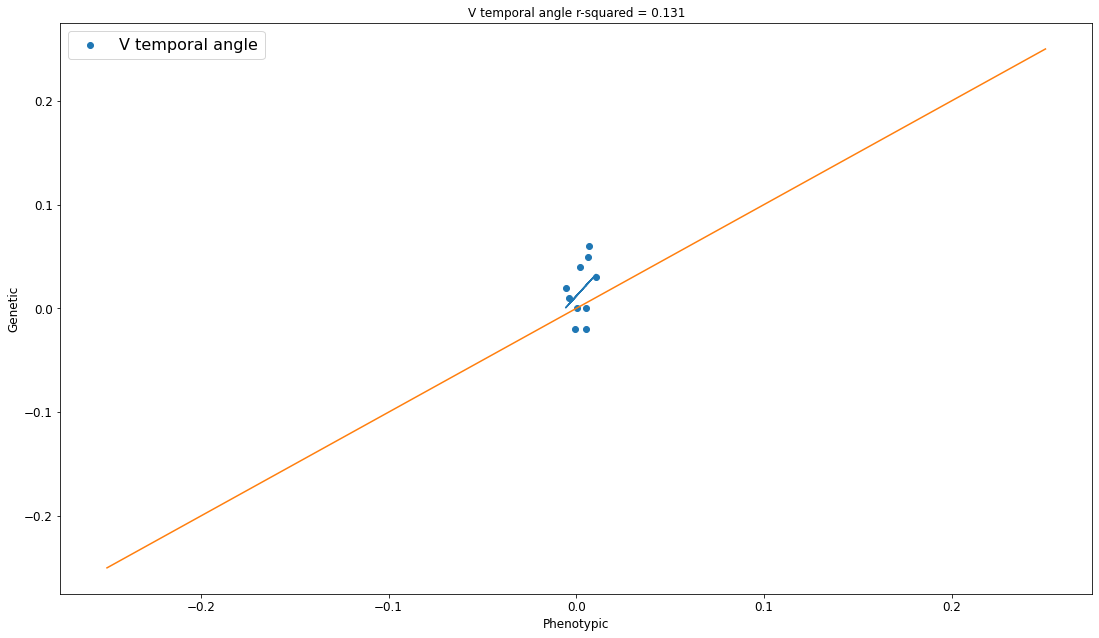

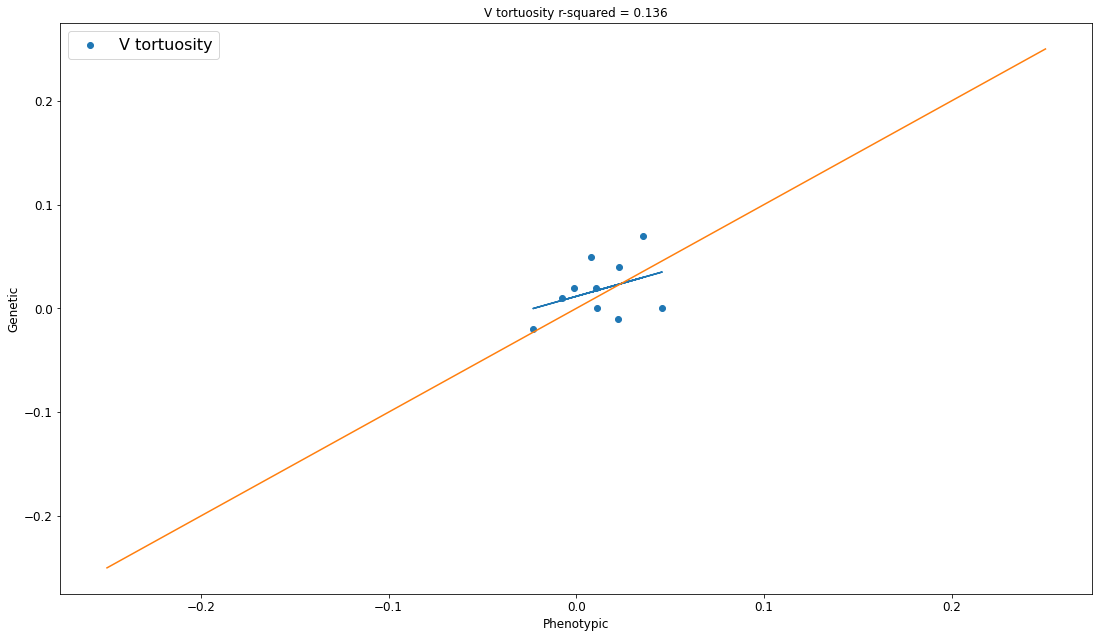

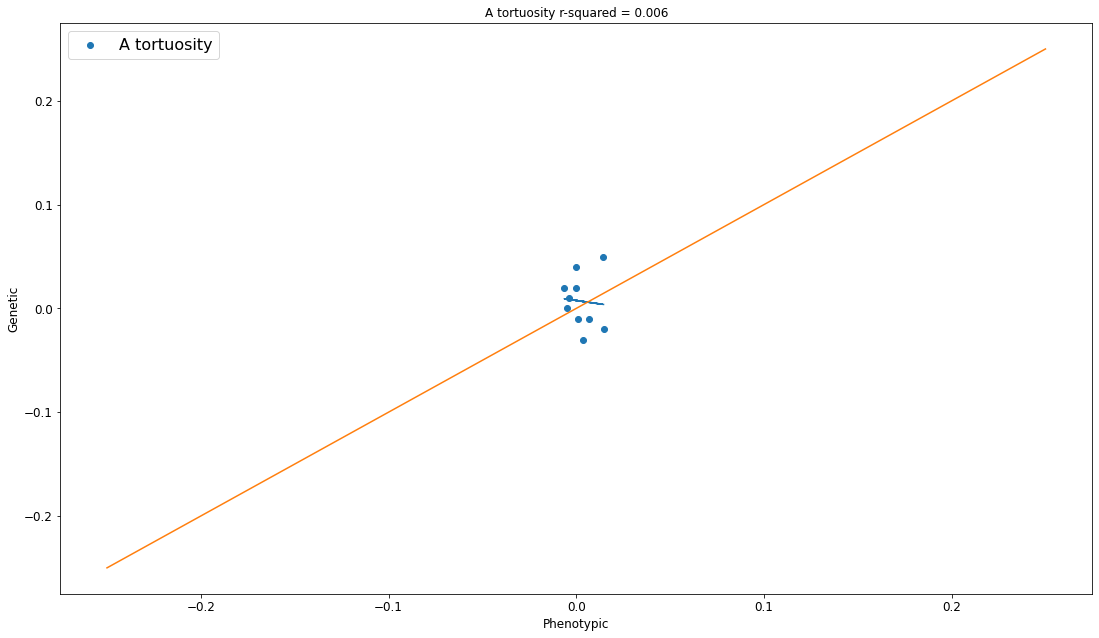

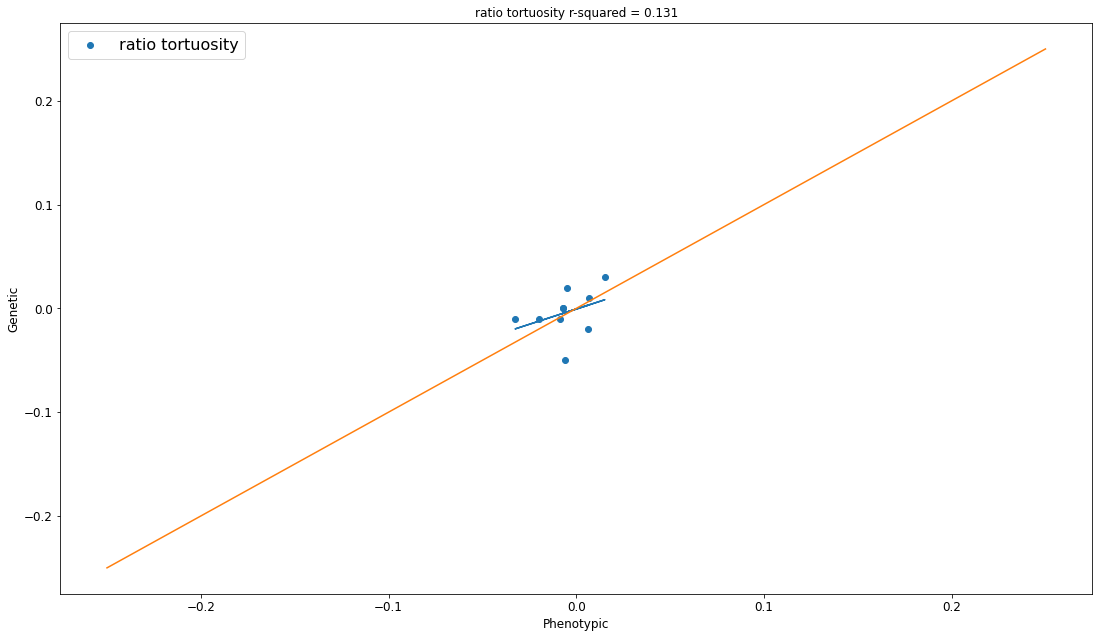

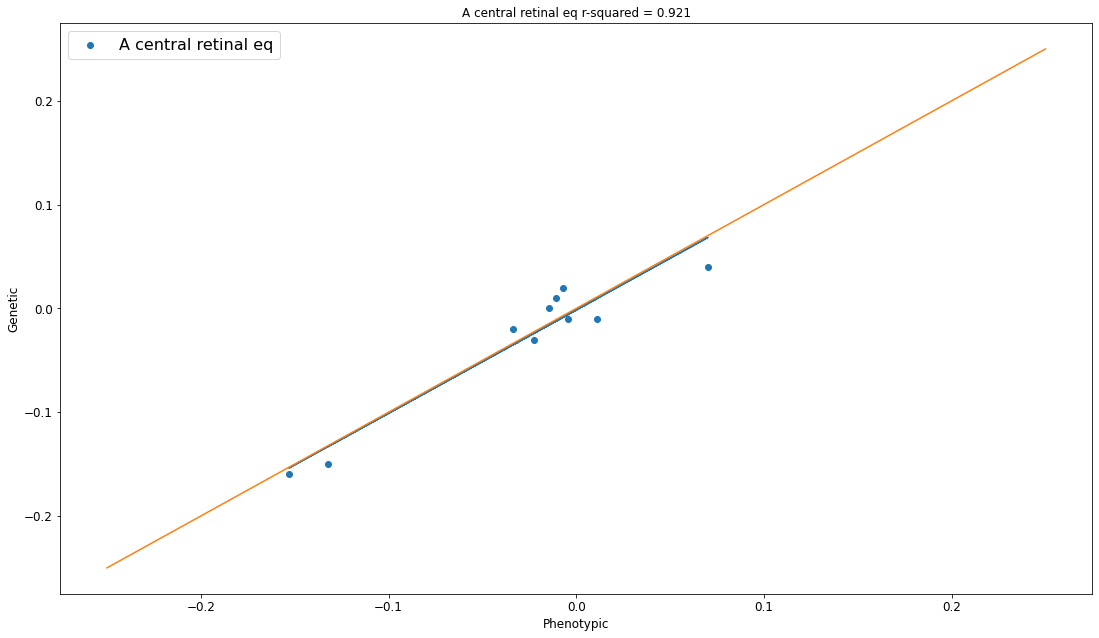

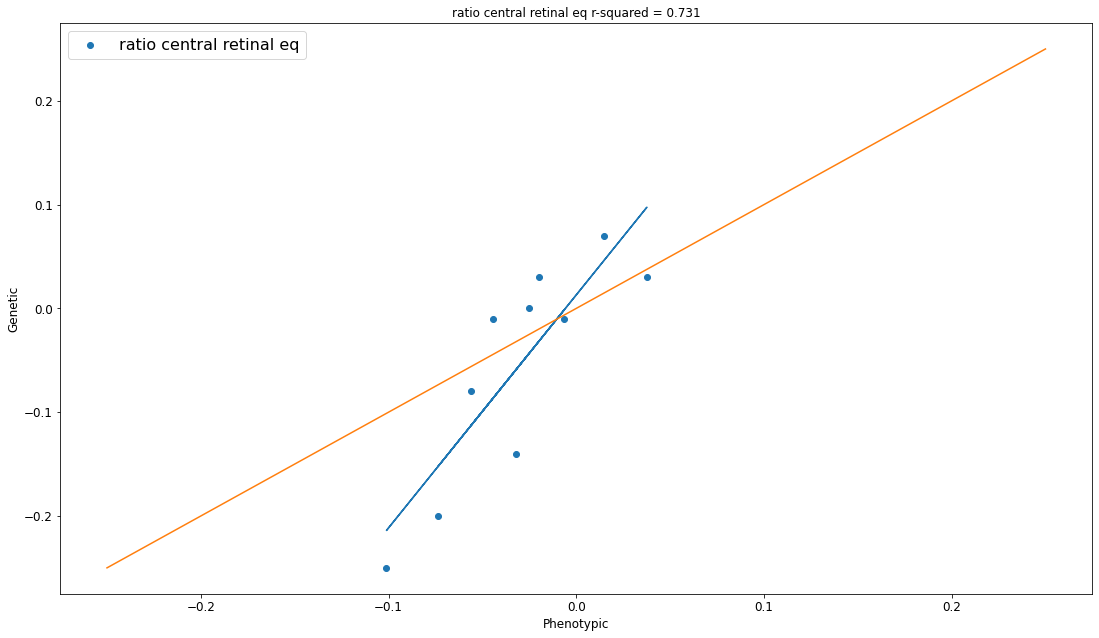

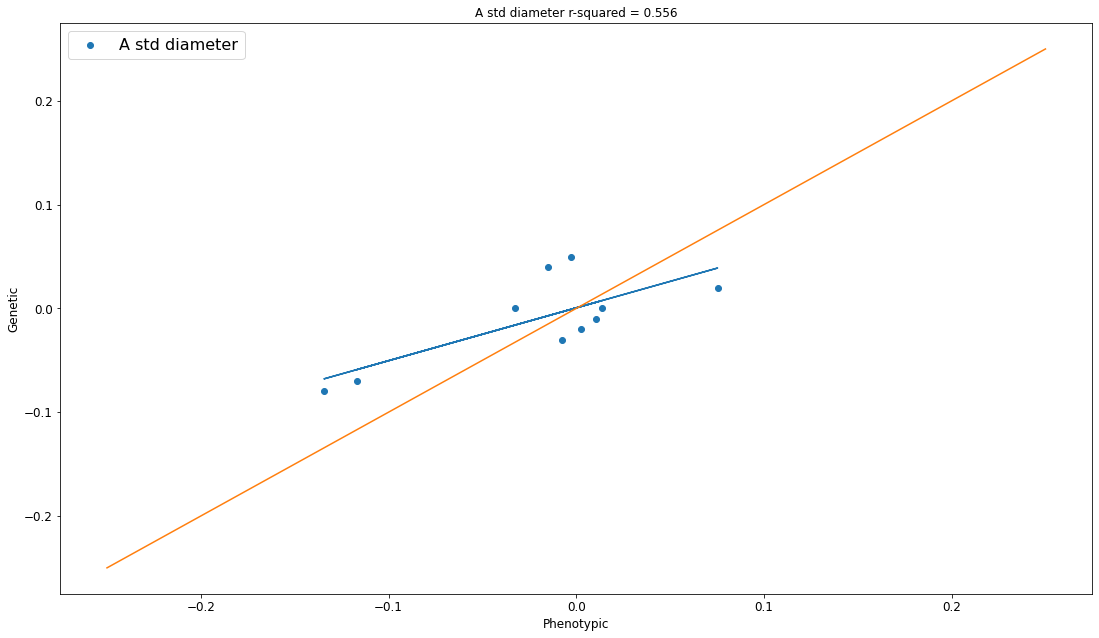

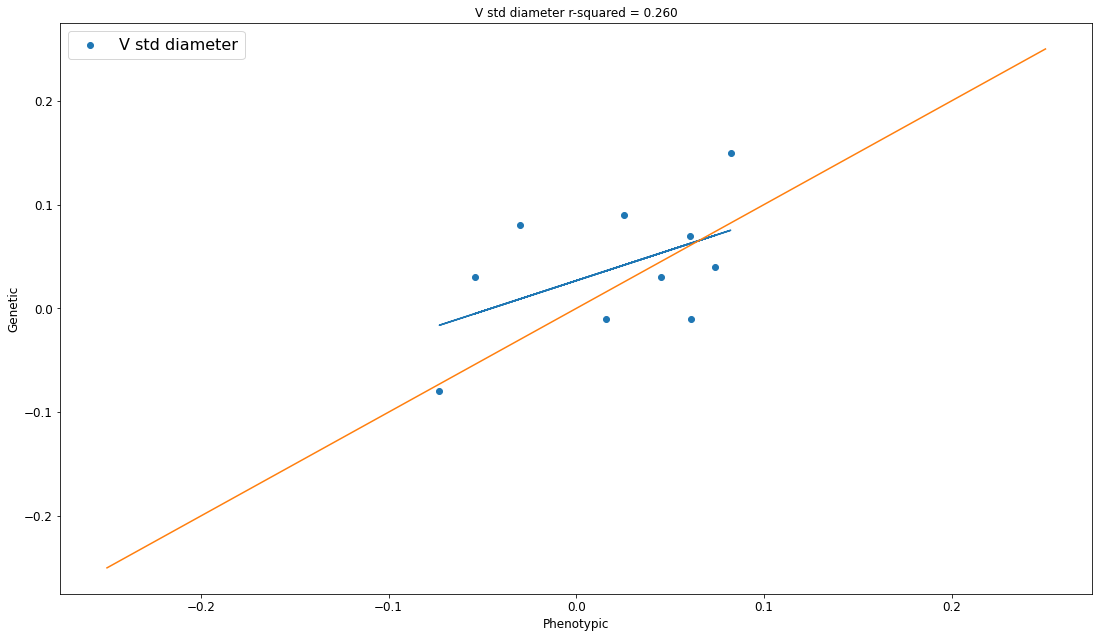

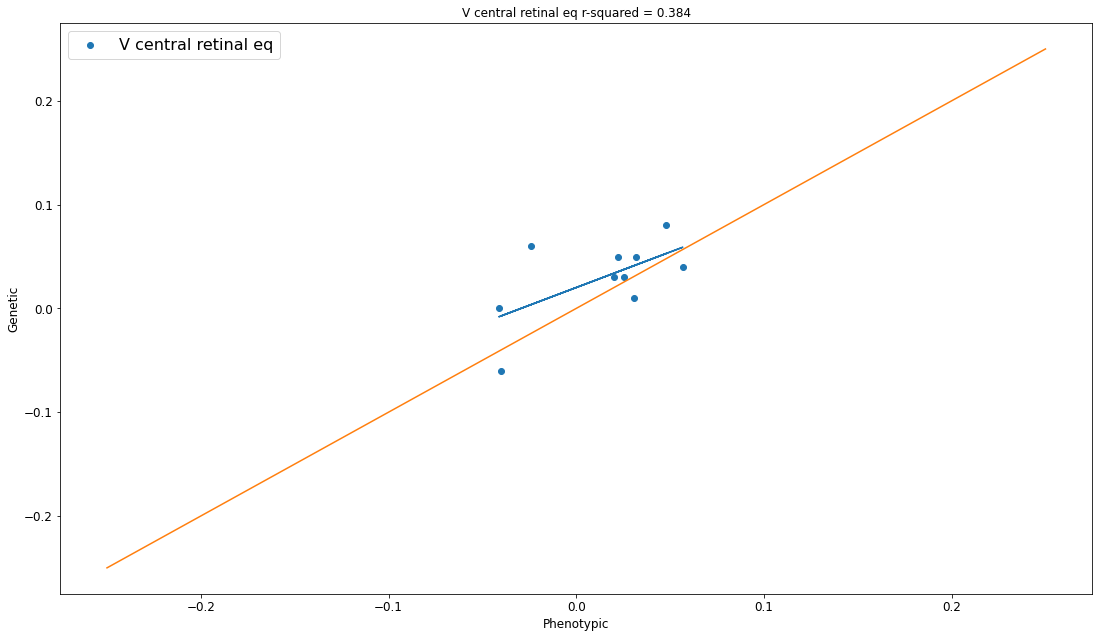

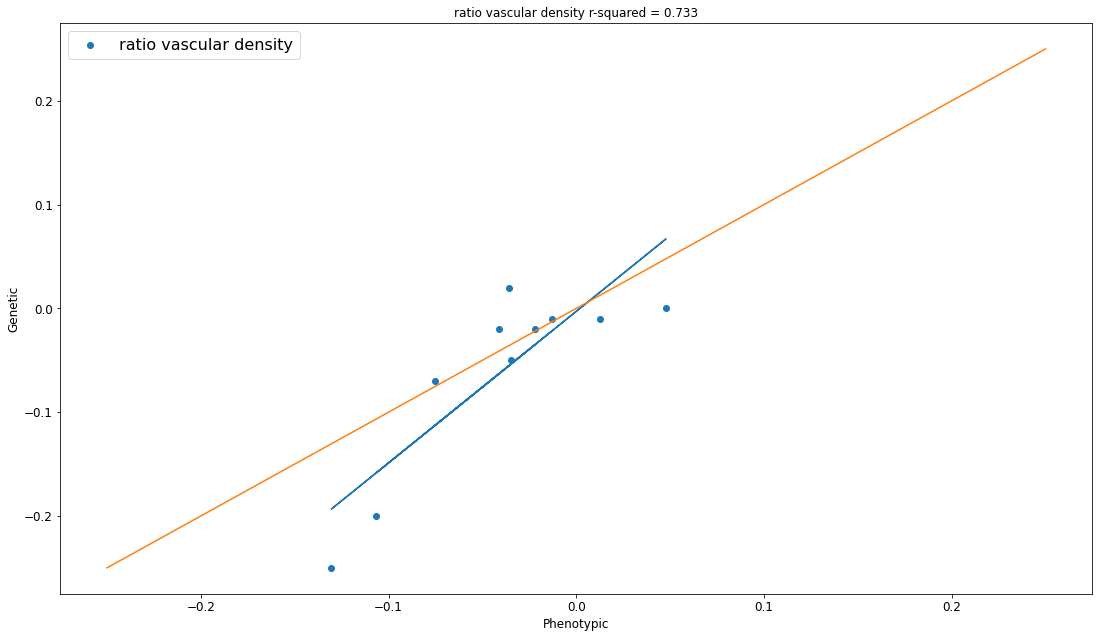

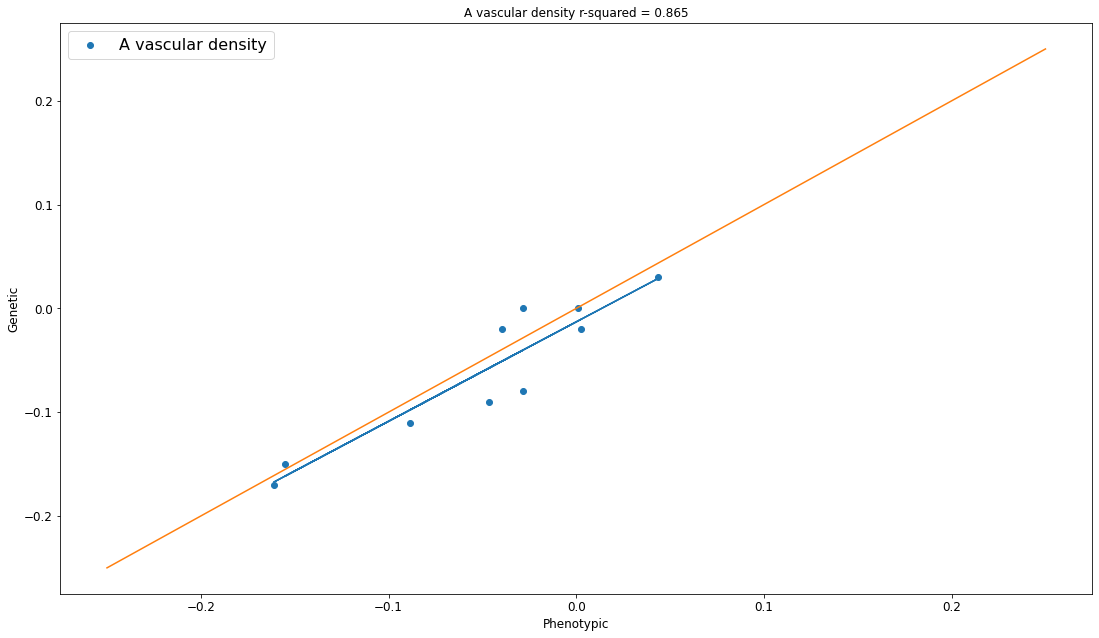

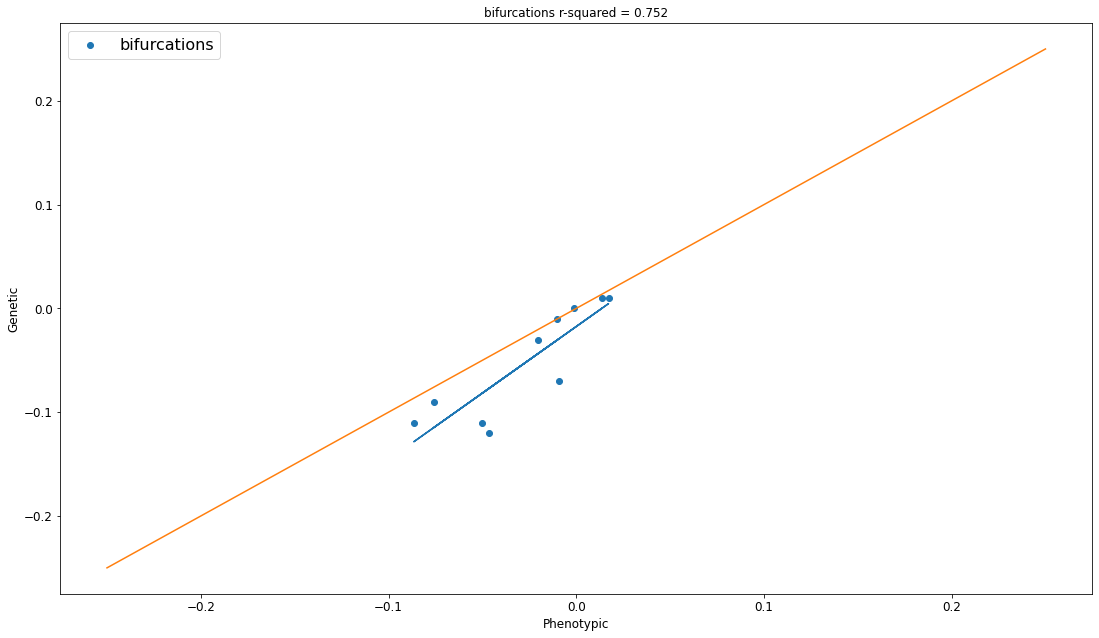

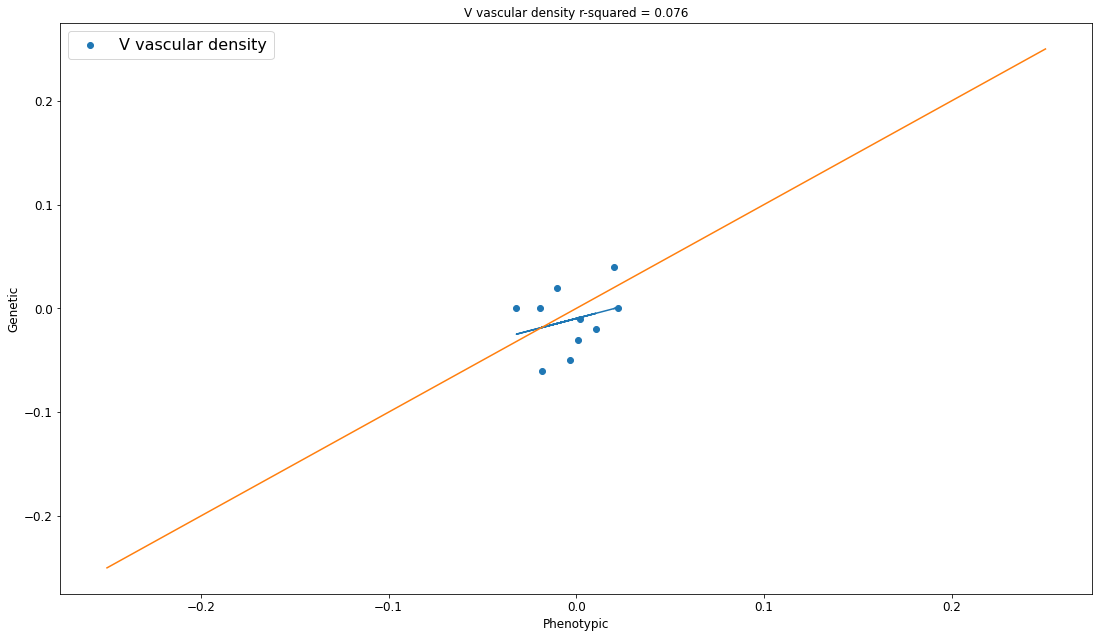

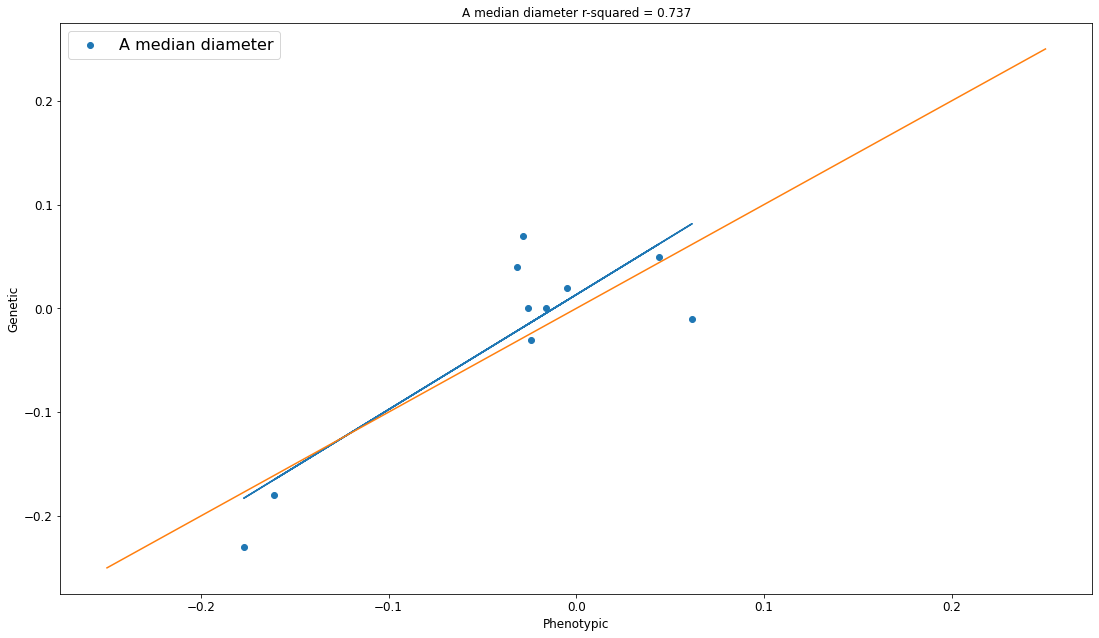

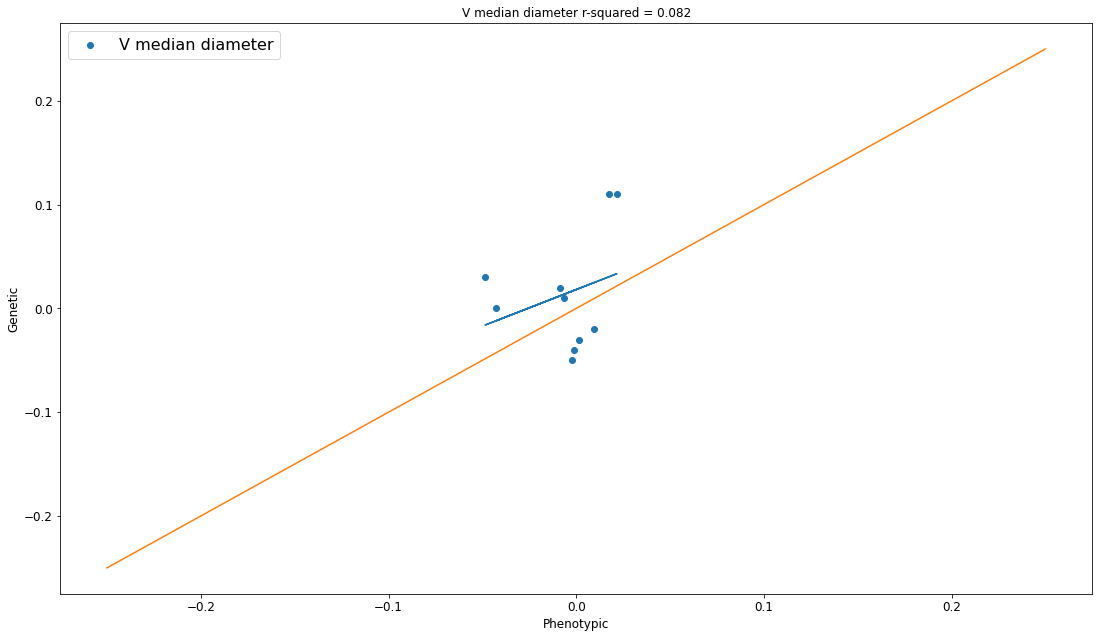

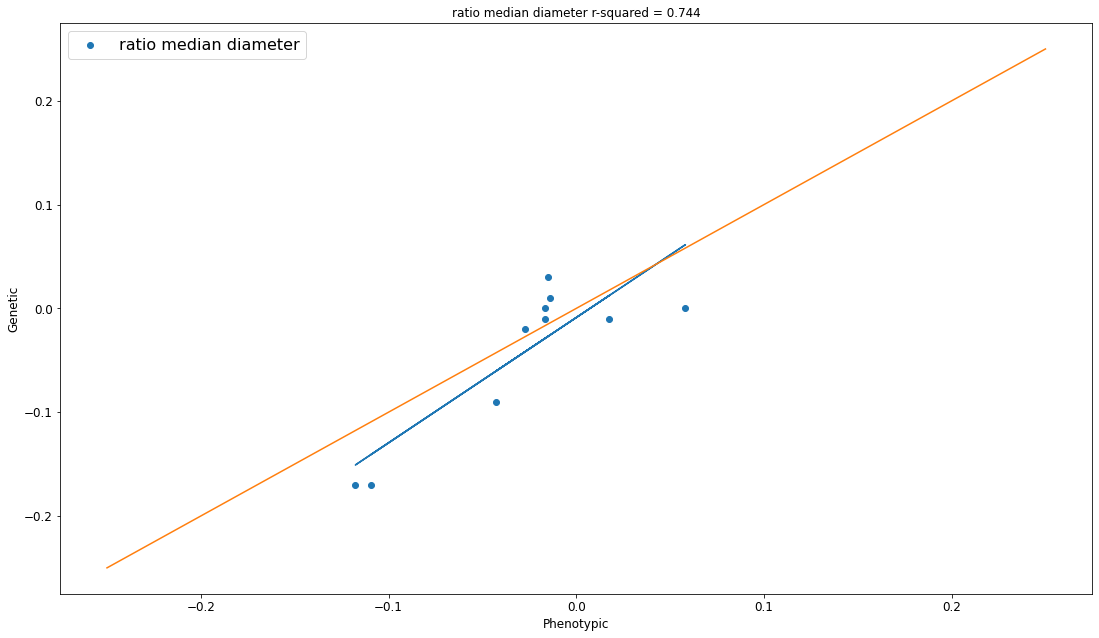

In [59]:
def phen_gen_scatter_one_at_the_time_diag_tend(df_1, df_2):
    l_aux = []
    for col in df_1.columns:
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.scatter(x=df_1[col], y=df_2[col], label=col)  #, c=df_2.index, cmap="Set3")
        z = np.polyfit(np.array(df_1[col]), np.array(df_2[col]), 1)
        p = np.poly1d(z)
        #add trendline to plot
        plt.plot(np.array(df_1[col]), p(np.array(df_1[col])))
        ident = [-0.25, 0.25]
        plt.plot(ident,ident)
        r_value, r_value2 = rsquared(df_1[col], df_2[col])
        plt.legend(loc='best', fontsize=16)
        #print( col , r_value2)
        plt.xlabel('Phenotypic')
        plt.ylabel('Genetic')
        plt.title(col + " r-squared = {:.3f}".format(r_value2))
        plt.show()

        data={
            'col':  col,
            'r_value':  r_value,
            'r_value2':  r_value2
            }
        l_aux.append(data)
        
    return pd.DataFrame(l_aux)


df_continuos_R = phen_gen_scatter_one_at_the_time_diag_tend(betas_intersection, df_corr_minus_std_intersection)

df_T_continuos_R =phen_gen_scatter_one_at_the_time_diag_tend(betas_intersection.T, df_corr_minus_std_intersection.T)


# Not intersection traits ('manual biyection')

In [60]:
print('ATENTION! -> Phenoty and genetically we have different sizes, we do not have biyective function between them. So it is needed to make decisions')
print('len(df_corr_minus_std) and len(betas): ', len(df_corr_minus_std), len(betas))
#print(df_corr_minus_std.index, betas.index)
list_pheno_not_geno = list(set(betas.index) - set(list_intersection_phe_gen))
list_geno_not_pheno = list(set(df_corr_minus_std.index) - set(list_intersection_phe_gen))
print('Pheno not Geno ', len(list_pheno_not_geno), ' -> names: ', list_pheno_not_geno)
print('Geno not Pheno ', len(list_geno_not_pheno), ' -> names: ', list_geno_not_pheno)


#df_corr_minus_std_geno_not_pheno = df_corr_minus_std.T[list_geno_not_pheno]
#df_corr_minus_std_geno_not_pheno.columns()

#plt.scatter(x= betas.T['Cataract'], y=df_corr_minus_std.T['Cataract *'])

ATENTION! -> Phenoty and genetically we have different sizes, we do not have biyective function between them. So it is needed to make decisions
len(df_corr_minus_std) and len(betas):  23 32
Pheno not Geno  22  -> names:  ['Glaucoma', "Alzheimer's disease", 'PE', 'N_cigarettes_curr_daily_both', 'Astigmatism', 'Hypermetropia', 'Cataract', 'Stroke', 'Heart attack', 'Other ED', 'Diabetes-eye', 'Mortality', 'Presbyopia', 'Amblyopia', 'Atherosclerosis', 'Myopia', 'DVT', 'Angina', 'Smoking', 'Hypertension', 'date_disorders_arteries_arterioles', 'Diabetes']
Geno not Pheno  13  -> names:  ['Smoking status: Previous *', 'Glasses myopia *', 'Glasses hypermetropia *', 'Smoking status: current *', 'Heart attack *', 'Diabetes *', 'Smoking status: Never *', 'Hypertension *', 'Angina *', 'Coronary atherosclerosis *', 'Stroke *', 'Glaucoma *', 'Cataract *']


KeyError: 'High blood pressure'

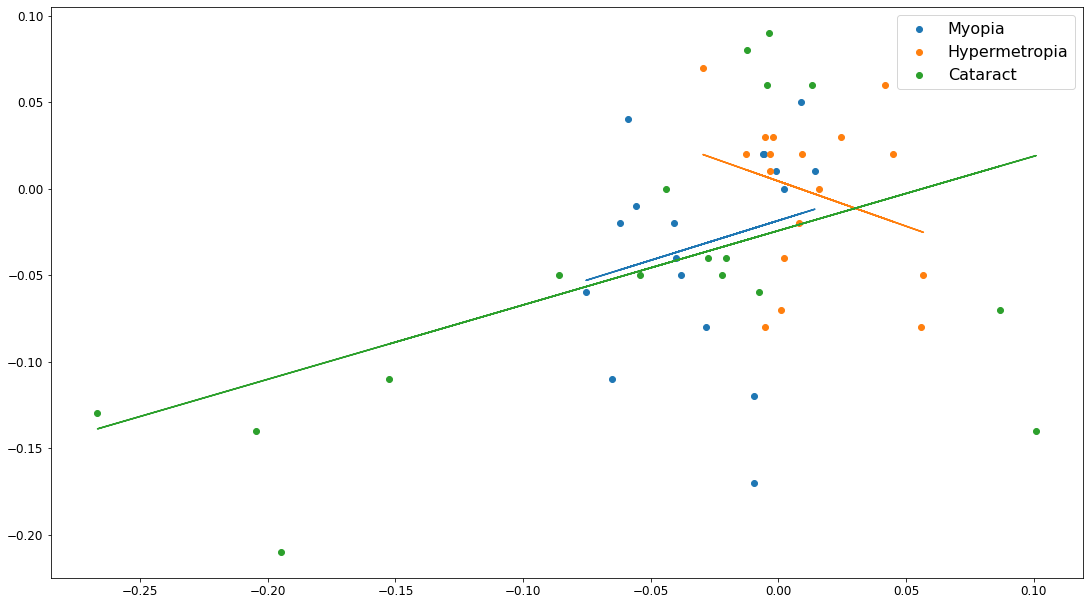

In [61]:
def binary_phen_gen_scatter_one_at_the_time_diag_tend(df_1, df_2, list_pheno_diseases, list_gen_diseases):
    counter = 0
    l_aux = []
    for col in list_pheno_diseases:
        col2 = list_gen_diseases[counter]
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.scatter(x=df_1[col], y=df_2[col2], label=col)  #, c=df_2.index, cmap="Set3")
        z = np.polyfit(np.array(df_1[col]), np.array(df_2[col2]), 1)
        p = np.poly1d(z)
        #add trendline to plot
        plt.plot(np.array(df_1[col]), p(np.array(df_1[col])))
        ident = [-0.25, 0.25]
        plt.plot(ident,ident)
        r_value, r_value2 = rsquared(df_1[col], df_2[col2])
        plt.legend(loc='best', fontsize=16)
        #print( col , r_value2)
        plt.xlabel('Phenotypic')
        plt.ylabel('Genetic')
        plt.title(col + ' '+ col2 + " r-squared = {:.3f}".format(r_value2))
        plt.show()
        counter= counter + 1

        data={
            'col':  col,
            'r_value':  r_value,
            'r_value2':  r_value2
            }
        l_aux.append(data)
        
    return pd.DataFrame(l_aux)


def binary_phen_gen_scatter_diag_tend(df_1, df_2, list_pheno_diseases, list_gen_diseases):
    counter = 0
    for col in list_pheno_diseases:
        col2 = list_gen_diseases[counter]
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.scatter(x=df_1[col], y=df_2[col2], label=col)  #, c=df_2.index, cmap="Set3")
        plt.legend(loc='best', fontsize=16)
        z = np.polyfit(np.array(df_1[col]), np.array(df_2[col2]), 1)
        p = np.poly1d(z)
        #add trendline to plot
        plt.plot(np.array(df_1[col]), p(np.array(df_1[col])))
        counter= counter + 1
    ident = [-0.3, 0.3]
    plt.plot(ident,ident)
    plt.xlabel('Phenotypic')
    plt.ylabel('Genetic')
    plt.title('Binary traits')
    plt.show()


list_pheno_diseases = ['Myopia', 'Hypermetropia', 'Cataract', 'High blood pressure', 'Angina', 'Diabetes', 'Stroke', 'Heart attack', 'Pack smoked per year']
list_gen_diseases = ['Glasses myopia *', 'Glasses hypermetropia *', 'Cataract *', 'High blood pressure *', 'Angina *', 'Diabetes *','Stroke *', 'Heart attack *', 'Smoking status: current *']

#phen_gen_scatter_one_at_the_time_diag_tend(betas_intersection, df_corr_minus_std_intersection, list_pheno_diseases, list_gen_diseases)

binary_phen_gen_scatter_diag_tend(betas.T, df_geno_used_binary, list_pheno_diseases, list_gen_diseases )
df_binary_R= binary_phen_gen_scatter_one_at_the_time_diag_tend(betas.T, df_geno_used_binary, list_pheno_diseases)


In [ ]:
#df_continuos_R.plot.bar(y='r_value', x='col')
#df_continuos_R.plot.bar(y='r_value2', x='col')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
df_continuos_R.plot.bar(y='r_value', x='col', ax=ax1)
plt.xticks(rotation=45, ha='right')
df_binary_R.plot.bar(y='r_value', x='col',ax=ax2)
plt.xticks(rotation=45, ha='right')
plt.title('r value (between phenotypic/genetic corr) for continues and binary traits')
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
df_continuos_R.plot.bar(y='r_value2', x='col', ax=ax1)
plt.xticks(rotation=45, ha='right')
df_binary_R.plot.bar(y='r_value2', x='col',ax=ax2)
plt.xticks(rotation=45, ha='right')
plt.title('r2 value (between phenotypic/genetic corr) for continues and binary traits')
plt.show()


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
df_continuos_R.plot.bar(y='r_value', x='col', ax=ax1)
xlabels1 = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels1, rotation=45,  ha='right')
df_continuos_R.plot.bar(y='r_value2', x='col', ax=ax2)
xlabels2 = ax2.get_xticklabels()
ax2.set_xticklabels(xlabels2, rotation=45,  ha='right')
#plt.title('r and r2 value (between phenotypic/genetic corr) for continues traits')
plt.show()